## Tapping Playground

This notebooks investigates optimal hand- and fingertapping algorithms as part of the 
ReTune-Dyskinesia project.



### 0. Loading packages and functions, defining paths



In [1]:
# Importing Python and external packages
import os
import sys
import importlib
import pandas as pd
import numpy as np
import sklearn as sk
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy import stats
from array import array
import datetime as dt
import h5py
from dataclasses import  dataclass, field
from itertools import compress
from typing import Any

In [2]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
# print('mne_bids', mne_bids.__version__)
# print('mne', mne.__version__)
print('sci-py', scipy.__version__)
print('sci-kit learn', sk.__version__)
## FEB 2022:
# Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
# [Clang 10.0.0 ]
# pandas 1.3.4
# numpy 1.20.3
# mne_bids 0.9
# mne 0.24.1
# sci-py 1.7.1
# sci-kit learn 1.0.1

Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
pandas 1.3.4
numpy 1.20.3
sci-py 1.7.1
sci-kit learn 1.0.1


In [3]:
# define local storage directories
projectpath = '/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys'
codepath = os.path.join(projectpath, 'code')
pynmd_path = os.path.join(codepath, 'py_neuromodulation')
rawdatapath = '/Users/jeroenhabets/OneDrive - Charité - Universitätsmedizin Berlin/BIDS_Berlin_ECOG_LFP/rawdata'
proc_data_path = os.path.join(projectpath, 'data/preprocess')
# change working directory to project-code folder
os.chdir(projectpath)
temp_save = os.path.join(projectpath, 'figures/TEMP')
os.getcwd()

'/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys'

In [4]:
os.chdir(codepath)
# own data preprocessing functions
import lfpecog_preproc.preproc_data_management as dataMng
# own data exploration functions
import lfpecog_features.feats_read_data as read_data
import lfpecog_features.tapping_preprocess as tap_preproc
import lfpecog_features.tapping_find_blocks as find_blocks
import lfpecog_features.tapping_impact_finder as tap_impact
# import lfpecog_features.handTap_detect as handTap_detect
import lfpecog_features.handTap_detect2 as Tap2
import lfpecog_features.tapping_run as tap_run
import lfpecog_features.tapping_featureset as tap_fts_set
import lfpecog_features.tapping_extract_features as tap_ft_extr

import lfpecog_preproc.preproc_resample as resample

import lfpecog_features.updrsTapping_import as tap_import

os.chdir(projectpath)




sub functions imported


## ACC Analysis Johannes

In [1322]:
## Loading Data single patients
dlFolder = '/Users/jeroenhabets/Downloads'
csvfiles = [f for f in os.listdir(dlFolder) if f[-3:] == 'csv']
txtfiles = [f for f in os.listdir(dlFolder) if f[-3:] == 'txt']
matfiles = [f for f in os.listdir(dlFolder) if f[-3:] == 'mat']

# single patient file recognition
for f in csvfiles:
    if '540AE' in f:
        if 'StimOn' in f: f_40on = os.path.join(dlFolder, f)
        if 'StimOff' in f: f_40off = os.path.join(dlFolder, f)

    if '537BI' in f:
        if 'StimOn' in f: f_37on = os.path.join(dlFolder, f)
        if 'StimOff' in f: f_37off = os.path.join(dlFolder, f)

# big file recognition
for f in csvfiles:
    if f[:7] == 'taps_JB':
        bigcsvfile = f
for f in txtfiles:
    if f[:4] == 'taps':
        bigtxtfile = f

In [1325]:
dlFolder

'/Users/jeroenhabets/Downloads'

In [1323]:
## Loading big file containing 140 many traces
file = open(os.path.join(dlFolder, bigtxtfile), 'rb')
bigAcc = np.loadtxt(file, delimiter = ",")

ValueError: Wrong number of columns at line 27

In [401]:
@dataclass(init=True, repr=True, )
class detectTapsOld:
    """
    Class to detect and store Taps of Acc-Trace (140 traces)
    """
    classStruct: bool
    accSig: Any
    fs: int
    Off: Any = None
    On: Any = None
    taps: Any = None  # for none classstructure

    def __post_init__(self,):
        if self.classStruct:
                offInd, offTimes, _ = Tap2.continTapDetector(
                        y=getattr(self.accSig, 'Off'), fs=fs,)
                self.Off = offInd
                onInd, onTimes, _ = Tap2.continTapDetector(
                        y=getattr(self.accSig, 'On'), fs=fs,)
                self.On = onInd
        else:
                ind, times, _ = Tap2.continTapDetector(
                        y=self.accSig, fs=fs,)
                self.taps = ind
                

In [398]:
# Create Data Classes
# create patient on/off Acc Classes
fs=250

accDat = {
    '37': accData(OnFile=f_37on, OffFile=f_37off),
    '40': accData(OnFile=f_40on, OffFile=f_40off,),
}

In [402]:
# Detect Taps
importlib.reload(Tap2)
accTaps = {
    '37': detectTapsOld(
        accSig=accDat['37'], fs=fs, classStruct=True),
    '40': detectTapsOld(
        accSig=accDat['40'], fs=fs, classStruct=True),
}

In [410]:
importlib.reload(tap_extract_fts)

## Calculate Features Class
tapFts = {}
for sub in accTaps.keys():
    tapFts[sub] = {}
    for stim in ['Off', 'On']:
        tapFts[sub][stim] = tap_extract_fts.tapFeatures(
            tapDict=getattr(accTaps[sub], stim),
            fs=250,
            accSig=getattr(accDat[sub], stim),
        )


In [935]:
for sub in ['37', '40']:
    for state in ['Off', 'On']:
        print('\n', sub, state,)
        print(f'Number of total taps: {tapFts[sub][state].nTaps}')
        print(f'Number of good taps: {tapFts[sub][state].nGoodTaps}')
        print('Mean duration (sd): '
            f'{round(tapFts[sub][state].duration.mean(), 2)} (+/- '
            f'{round(tapFts[sub][state].duration.std(), 1)}) sec')
        print('Overall tap-frequency: '
            f'{tapFts[sub][state].freq} Hz')
        print('Mean max Up-Velocity (sd): '
            f'{np.nanmean(tapFts[sub][state].maxVelUp)} (+/- '
            f'{np.nanstd(tapFts[sub][state].maxVelUp)}) m/s')
        print('Mean crossing 0-line (sd): '
            f'{np.nanmean(tapFts[sub][state].dirChange)} (+/- '
            f'{np.nanstd(tapFts[sub][state].dirChange)}) times/tap')
        print('Mean RMS (sd): '
            f'{np.nanmean(tapFts[sub][state].RMS)} (+/- '
            f'{np.nanstd(tapFts[sub][state].RMS)})')


 37 Off
Number of total taps: 102
Number of good taps: 34
Mean duration (sd): 0.26 (+/- 0.2) sec
Overall tap-frequency: 3.8 Hz
Mean max Up-Velocity (sd): 4.824931044835947e-05 (+/- 2.9672203475780716e-05) m/s
Mean crossing 0-line (sd): 5.7745098039215685 (+/- 4.354188568842781) times/tap
Mean RMS (sd): 1.6164760837032009e-06 (+/- 4.364309195205036e-07)

 37 On
Number of total taps: 102
Number of good taps: 52
Mean duration (sd): 0.26 (+/- 0.3) sec
Overall tap-frequency: 3.8 Hz
Mean max Up-Velocity (sd): 2.0601591689475344e-05 (+/- 7.1702875508905846e-06) m/s
Mean crossing 0-line (sd): 6.833333333333333 (+/- 14.187873400689297) times/tap
Mean RMS (sd): 1.2933541185364969e-06 (+/- 4.332169503520449e-07)

 40 Off
Number of total taps: 86
Number of good taps: 36
Mean duration (sd): 0.33 (+/- 0.1) sec
Overall tap-frequency: 3.0 Hz
Mean max Up-Velocity (sd): 6.365487415971885e-05 (+/- 7.858898254436998e-06) m/s
Mean crossing 0-line (sd): 9.279069767441861 (+/- 4.773110639947394) times/tap
M

In [989]:
### Calculate 140 traces file
importlib.reload(Tap2)

## Resample big data
fs_org = 4000
fs_new = 250
dat140 = np.zeros((
    bigAcc.shape[0],
    bigAcc.shape[1] // fs_org * fs_new))
for row in range(bigAcc.shape[0]):
    dat140[row, :] = signal.resample(
        bigAcc[row, :], 
        max(bigAcc.shape) // (fs_org // fs_new)
    )
print('Resampling done')

# Detect taps per trace
taps140 = {}
for row in range(dat140.shape[0])[40:]:
    sig = dat140[row, :]
    tapClass = detectTapsOld(
        accSig=dat140[row, :], fs=fs, classStruct=False
    )
    taps140[row] = tapClass.taps
    print(f'Taps detected for trace #{row}')

## Calculate Features 140 traces
fts140 = {}
for n in taps140.keys():
    fts140[n] = tap_extract_fts.tapFeatures(
        tapDict=taps140[n],
        fs=250,
        accSig=dat140[n, :],
    )


Resampling done


/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Taps detected for trace #40
Taps detected for trace #41
Taps detected for trace #42
Taps detected for trace #43
Taps detected for trace #44
Taps detected for trace #45
Taps detected for trace #46
Taps detected for trace #47
Taps detected for trace #48
Taps detected for trace #49
Taps detected for trace #50
Taps detected for trace #51
Taps detected for trace #52
Taps detected for trace #53
Taps detected for trace #54
Taps detected for trace #55
Taps detected for trace #56
Taps detected for trace #57
Taps detected for trace #58
Taps detected for trace #59
Taps detected for trace #60
Taps detected for trace #61
Taps detected for trace #62
Taps detected for trace #63
Taps detected for trace #64
Taps detected for trace #65
Taps detected for trace #66
Taps detected for trace #67
Taps detected for trace #68
Taps detected for trace #69
Taps detected for trace #70
Taps detected for trace #71
Taps detected for trace #72
Taps detected for trace #73
Taps detected for trace #74
Taps detected for tr

/var/folders/7d/4ptht2m910d1y872jrgp9cq40000gp/T/ipykernel_38205/2063514711.py:22: RuntimeWarning: Mean of empty slice.
  self.freq = round(1 / self.duration.mean(), 1)


In [990]:
OUT = []
for i in fts140.keys():
    OUT.append(
        np.nanmean(abs(fts140[i].maxVelUp)) * fts140[i].nTaps
    )
# # save 140-traces features
# df = pd.DataFrame(data=OUT)
# df.to_csv(os.path.join(temp_save, '140traces_veloXntap.csv'))

/var/folders/7d/4ptht2m910d1y872jrgp9cq40000gp/T/ipykernel_38205/90103641.py:4: RuntimeWarning: Mean of empty slice
  np.nanmean(abs(fts140[i].maxVelUp)) * fts140[i].nTaps


In [773]:
# Plot detected TAPS

importlib.reload(Tap2)
accTaps = {}
# taps40 = {}
for sub in ['37', '40']:
    accdat = accDat[sub]
    accTaps[sub] = {}
    states = ['Off', 'On']

    fig, axes = plt.subplots(len(states), 1, figsize=(12, 6))

    for n, state in enumerate(states):
        sig = getattr(accdat, state)
        tapInd, tapT, endPeaks = Tap2.ContTapDetector(y=sig, fs=250,)
        accTaps[sub][state] = tapInd
        continue
        axes[n].plot(sig, label='y', alpha=.8, c='green')
        axes[n].plot(np.diff(sig), alpha=.8, c='purple', ls='dotted')
        axes[n].scatter(endPeaks, sig[endPeaks], c='purple')
        for tapi in tapInd:
            axes[n].scatter(tapi[0], sig[tapi[0]], c='g')
            if tapi[1] is not np.nan:
                axes[n].scatter(tapi[1], sig[tapi[1]], c='cyan', s=80)
            axes[n].scatter(tapi[-1], sig[tapi[-1]], c='r')
            if np.nan not in tapi:
                # print(tapi)
                axes[n].fill_betweenx(
                    y=np.linspace(-4e-6, 4e-6, 5),
                    x1=tapi[0],
                    x2=tapi[-1],
                    alpha=.3,)
            else:
                axes[n].fill_betweenx(
                    y=np.linspace(-4e-6, 4e-6, 5),
                    x1=tapi[0],
                    x2=tapi[-1], hatch='//', facecolor='w',
                    alpha=.3,)

        # axes[n].axhline(np.percentile(sig, 90), c='orange', ls='dashed')
        # axes[n].axhline(np.percentile(sig, 10), c='orange', ls='dashed')

        xticks = np.linspace(0, sig.shape[0], 17)
        # ax.set_xticks(xticks)
        # ax.set_xticklabels(xticks / fs)
        axes[n].set_xlabel('Time (seconds)')
        # ax.legend(ncol=6)
        axes[n].set_xlim(0, 4000)

        axes[n].set_title(state)

    # ax.plot(np.diff(sig), c='b', ls='dotted', alpha=.5,)
    plt.close()


1114


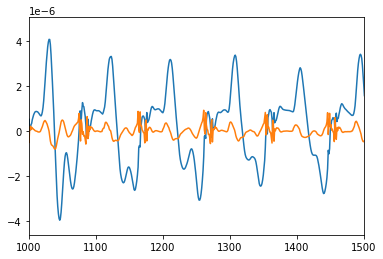

In [896]:
# ### SMOOTHING FUNCTION WITH NP.CONVOLVE

# sig = accDat['40'].On
# dfsig = np.diff(sig)

# kernel_size = 10
# kernel = np.ones(kernel_size) / kernel_size
# sigSm = np.convolve(sig, kernel, mode='same')
# dfSm = np.convolve(dfsig, kernel, mode='same')

# count = 0
# for i, df in enumerate(dfSm[1:]):
#     if df * dfSm[i] < 0: count += 1

# plt.plot(sigSm)
# plt.plot(dfSm)

# plt.xlim(1000, 1500)


# print(count)

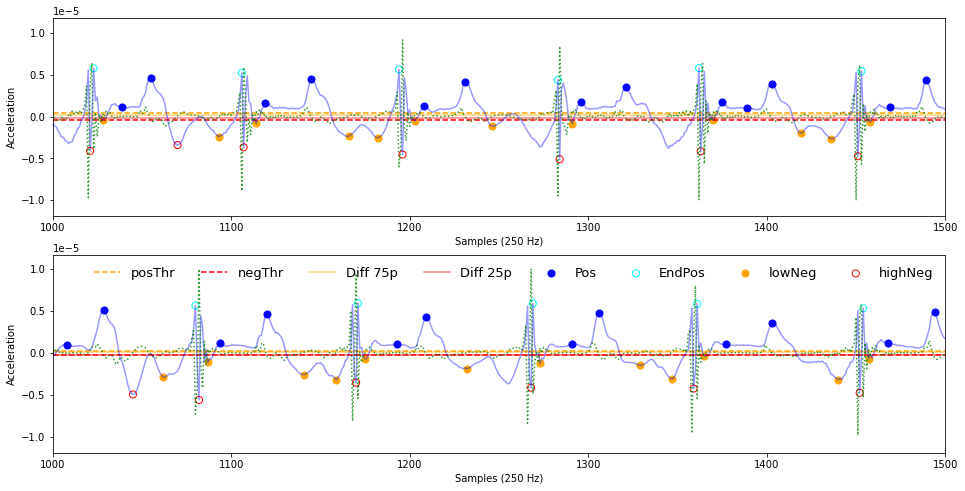

In [880]:
#### ALL IN TAP2 CONTTAP FUNCITON

sig37off = -acc37.Off * 1e-6
sig37on = -acc37.On * 1e-6
sig40on = acc40.On * 1e-6
sig40off = acc40.Off * 1e-6

fig, axes =plt.subplots(2, 1, figsize=(16, 8))

for a, sig in enumerate([acc40.Off, acc40.On]):
    sigdf = np.diff(sig)
    posThr = np.mean(sig)
    negThr = -np.mean(sig)
# smallPos = signal.find_peaks(
#     sig,
#     # height=(np.max(sig) * .1, np.max(sig) * .6),  # first value is min, second is max
#     height=(-np.max(sig) * .5, np.max(sig) * .1),
#     distance=fs * settings[task]['peak_dist'],
#     # prominence=np.max(sig) * .1,
#     # wlen=fs * settings[task]['peak_dist'],
# )
# largePos = signal.find_peaks(
#     sig,
#     height=np.max(sig) * .3,
#     distance=fs * settings[task]['peak_dist'],  # 1 s
# )
# find relevant positive peaks
    posPeaks = signal.find_peaks(
        sig,
        height=(posThr, np.max(sig)),
        distance=fs * .05,  # settings[task]['peak_dist']
    )[0]
    # select Pos-peaks with surrounding >> Pos and Neg Diff
    endPeaks = [np.logical_or(
        any(sigdf[i -3:i + 3] < np.percentile(sig, 10)),  #np.percentile(sig, 90) * .5)
        any(sigdf[i -3:i + 3] > np.percentile(sig, 90))
    ) for i in posPeaks]
    endPeaks = posPeaks[endPeaks]
    # delete endPeaks from posPeaks
    for i in endPeaks:
        idel = np.where(posPeaks == i)
        posPeaks = np.delete(posPeaks, idel)
    # delete endPeaks which are too close after each other
    # by starting with std False before np.diff, the diff-scores
    # represent the distance to the previous peak
    tooclose = endPeaks[np.append(
        np.array(False), np.diff(endPeaks) < (fs / 6))]
    for p in tooclose:
        i = np.where(endPeaks == p)
        endPeaks = np.delete(endPeaks, i)
        posPeaks = np.append(posPeaks, p)

    smallNeg = signal.find_peaks(
        -1 * sig,  # convert pos/neg for negative peaks
        height=(-.5e-7, abs(np.min(sig)) * .5),
        distance=fs * settings[task]['peak_dist'] * .5,
        prominence=abs(np.min(sig)) * .05,
        # wlen=40,
    )[0]

    largeNeg = signal.find_peaks(
        -1 * sig,
        height=abs(np.min(sig)) * .4,  # first value is min, second is max
        distance=fs * settings[task]['peak_dist'],
        # prominence=np.min(yEpoch) * .1,
        # wlen=40,
    )[0]

    axes[a].axhline(np.mean(sig), label='posThr', c='orange', ls='dashed')
    axes[a].axhline(-np.mean(sig), label='negThr', ls='dashed', c='r')
    axes[a].axhline(np.percentile(sigdf, 75), label='Diff 75p', c='orange', ls='solid', alpha=.5,)
    axes[a].axhline(np.percentile(sigdf, 25), label='Diff 25p', ls='solid', c='r', alpha=.5,)

    # ax.axhline(np.percentile(sig, 90), label='PERC-90', c='orange', ls='dotted')
    # ax.axhline(np.percentile(sig, 10), label='PERC-10', c='red', ls='dotted')

    axes[a].plot(sig, c='b', alpha=.4)
    axes[a].plot(np.diff(sig), c='green', ls='dotted', alpha=.8)

    peaklabel = ['Pos', 'EndPos', 'lowNeg', 'highNeg']
    for p, peaks in enumerate([posPeaks, endPeaks, smallNeg, largeNeg]):
        axes[a].scatter(
            peaks,
            sig[peaks],
            label=peaklabel[p],
            s=50,
            **col_pms[p],
        )

    axes[a].set_xlim(1000, 1500)

    axes[a].set_xlabel('Samples (250 Hz)')
    axes[a].set_ylabel('Acceleration')
plt.legend(ncol=8, fontsize=13, frameon=False)

plt.show()


## ACC Assessment Varvara's data

In [ ]:
### Future main.py-file

# input from json -> location of data (potential subs to exclude)
# tap_import.create_sub_side_lists() -> available patients + files
# pt-files -> tap_import.accData (class) per sub-side-state
# accClasses -> tapping_run.run_updrs_tapping(already_preprocd)


### 1a. Defining Data Import

In [20]:
# define folder-directory of tap-data
tap_dir = ('/Users/jeroenhabets/Research/'
            'CHARITE/projects/tapping')
acc_dir = os.path.join(
    tap_dir, 'data/test_taps_3x10s/20220520')

tap_prepr_dir = '/Users/jeroenhabets/Research/CHARITE/projects/tapping/figures/preprocessing'

### handle every sub-side as single sub
importlib.reload(tap_import)
sub_acc = {}
sub_sides, sub_side_files = tap_import.create_sub_side_lists(
    acc_dir)
print(f'Included subjects/sides to import: {sub_sides}')



Included subjects/sides to import: ['Sub007_L', 'Sub007_R', 'Sub014_L', 'Sub014_R', 'Sub015_L', 'Sub015_R', 'Sub013_L', 'Sub013_R']


### 1b. Importing and Preprocessing Acc-Tapping, incl. extraction active tapping blocks

In [19]:
importlib.reload(tap_import)
importlib.reload(find_blocks)

sub_sides_incl = [
        'Sub014_L', 'Sub014_R',
        'Sub007_L', 'Sub007_R',
        'Sub013_L', 'Sub013_R', 
        'Sub015_L', 'Sub015_R'
]
sub_acc, block_acc = {}, {}
for id_side in sub_sides_incl:
        key = id_side[3:]
        print('\nSTART', key)
        sub_acc[key] = tap_import.accData(
                OnFile=sub_side_files[id_side]['on'],
                OffFile=sub_side_files[id_side]['off'],
                orig_fs=250, wanted_fs=250,
                to_resample=False,
                to_check_polarity=True,
                to_check_magnOrder=True,
                verbose=False
        )
        print('Acc imported and preprocessed')
        for state in ['Off', 'On']:
                block_acc[f'{key}_{state}'], _ = find_blocks.find_active_blocks(
                        acc_arr=getattr(sub_acc[key], state),
                        fs=250, verbose=False
                )
                print(f'\tFor {key}, {state} block-arrays extracted')




START 014_L
Acc imported and preprocessed
	For 014_L, Off block-arrays extracted
	For 014_L, On block-arrays extracted

START 014_R
Acc imported and preprocessed
	For 014_R, Off block-arrays extracted
	For 014_R, On block-arrays extracted

START 007_L
Acc imported and preprocessed
	For 007_L, Off block-arrays extracted
	For 007_L, On block-arrays extracted

START 007_R
Acc imported and preprocessed
	For 007_R, Off block-arrays extracted
	For 007_R, On block-arrays extracted

START 013_L
Acc imported and preprocessed
	For 013_L, Off block-arrays extracted
	For 013_L, On block-arrays extracted

START 013_R
Acc imported and preprocessed
	For 013_R, Off block-arrays extracted
	For 013_R, On block-arrays extracted

START 015_L
Acc imported and preprocessed
	For 015_L, Off block-arrays extracted
	For 015_L, On block-arrays extracted

START 015_R
Acc imported and preprocessed
	For 015_R, Off block-arrays extracted
	For 015_R, On block-arrays extracted


In [780]:
def nan_array(nrows, ncols):
    """Create 2d np array with nan's"""
    arr = np.array(
        [[np.nan] * ncols] * nrows
    )

    return arr

### Feature Extraction

In [1245]:
from lfpecog_features.tapping_impact_finder import find_impacts
from lfpecog_features.tapping_preprocess import find_main_axis

In [1338]:
importlib.reload(tap_run)
importlib.reload(Tap2)
importlib.reload(tap_ft_extr)
importlib.reload(tap_fts_set)

fs=250

ids = ['014_L_On', '015_L_On', '007_L_On']

tapfeats = {}

for ID in ids:
    blocklist = block_acc[ID]
    tapfeats[ID] = {}
    for n, b in enumerate(blocklist):
        ax = find_main_axis(b)

        # extract features over acc-trace containing cont. tapping
        # either 30-sec task or selected 10-s blocks with function
        taps_temp, imp_temp = tap_run.run_updrs_tapping(
            acc_arr=b, fs=fs, already_preprocd=True
        )
        tapfeats[ID][f'B{n}'] = tap_ft_extr.tapFeatures(
            triax_arr=b,
            fs=fs,
            impacts=imp_temp,
            tapDict=taps_temp,  # result of continTap
        )


In [1345]:
featlist[0]

array([1.59219714, 1.66515254, 1.70942432, 1.55778704, 1.99173283,
       1.39624039, 1.85311554, 1.77452817, 1.61025037, 1.66549227,
       1.84003448, 1.52243575, 1.54755303, 1.59898175, 1.57022349,
       1.61749121, 1.51205622, 1.80988996, 1.41057946, 1.91287327,
       1.69190698, 1.76085755, 1.63423915, 1.47869487, 1.64400112,
       1.30500618, 1.90849019, 1.5264272 , 1.68424839, 1.81003988,
       1.38834884, 1.6646375 , 1.5062788 ])

IndexError: invalid index to scalar variable.

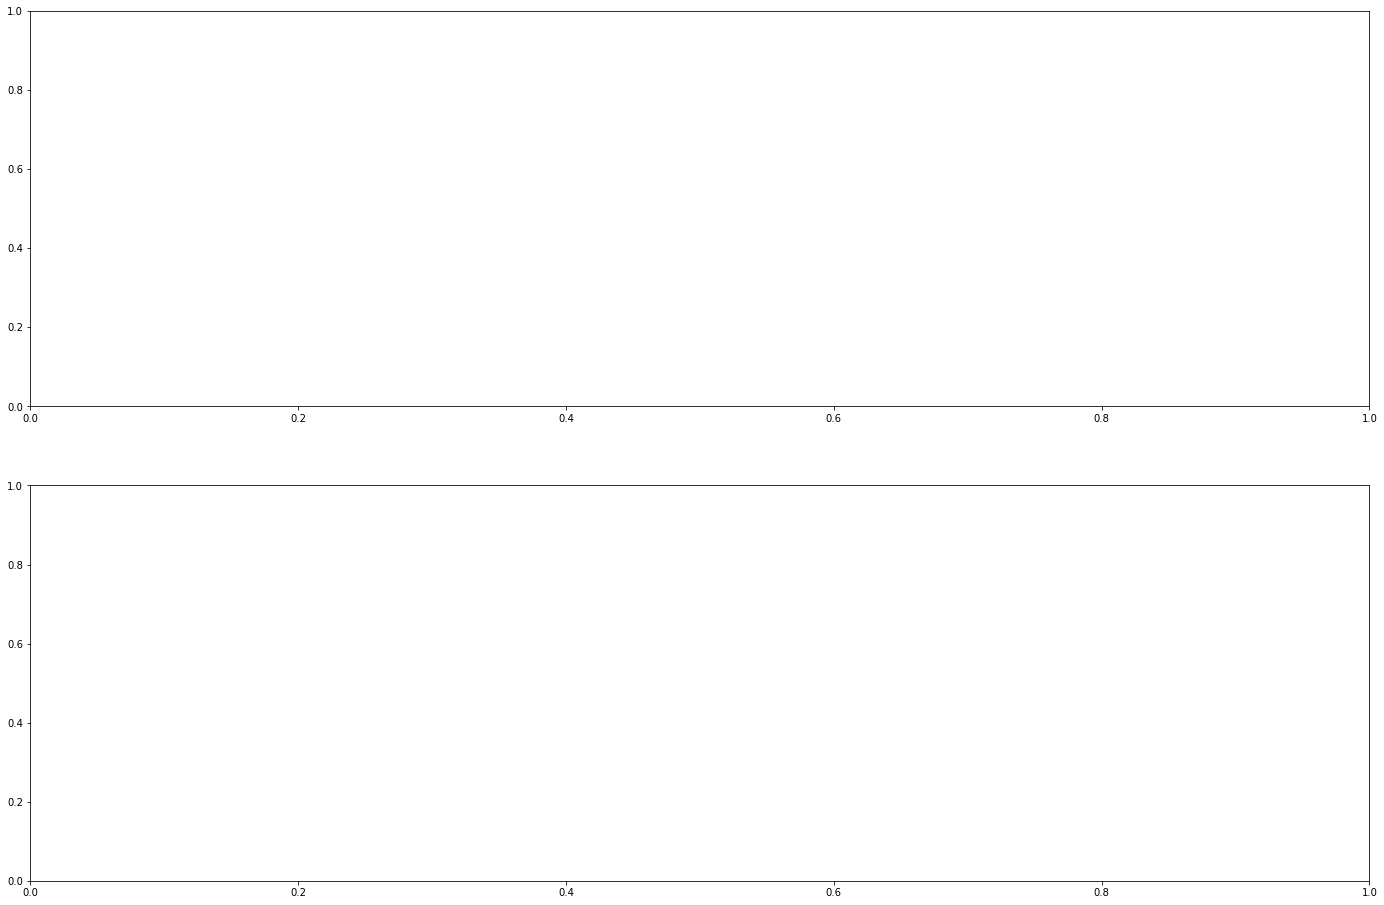

In [1343]:
fts_incl = [ 'RMS_ax', 'upVelo_ax']  #'nTaps', 'freq1',

plt.subplots(len(fts_incl), 1, figsize=(24, 16))

for iF, feat in enumerate(fts_incl):
    featlist = [
        getattr(tapfeats['014_L_On'][B], feat
        ) for B in tapfeats['014_L_On'].keys()]
    ax[iF].boxplot(featlist)

pltshow()

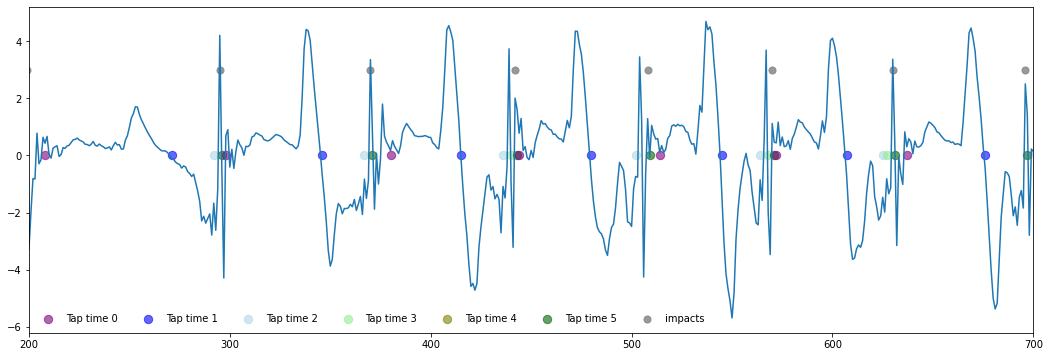

In [1303]:
tapdot_colors = [
    'purple', 'blue', 'lightblue',
    'lightgreen', 'olive', 'darkgreen']

plt.figure(figsize=(18,6))
plt.plot(b[ax])
for tap in taps0:
    for n, t in enumerate(tap):
        plt.scatter(t, [0], s=70, alpha=.6,
            c=tapdot_colors[n], label=f'Tap time {n}')

plt.scatter(imp0, [3] * len(imp0), label='impacts',
        c='gray', s=50, alpha=.8)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(
    by_label.values(), by_label.keys(),
    ncol=len(handles), frameon=False,
)
plt.xlim(200, 700)
plt.show()

### Johannes trace check

In [192]:
scores218 = np.genfromtxt(
    os.path.join(jb_dir, 'updrs_218.txt'),
    delimiter=',', dtype=str,
)
df_scores218 = pd.DataFrame(data=scores218[1:, :], columns=scores218[0, :])
arr_scores218 = scores218[1:, 2:]
scores545 = arr_scores218[-28:,:]


score_times = {
    '0': [],
    '1': [],
    '2': [],
    '3': [],
    '4': []
}

for r, run_id in enumerate(fts545.keys()):
    for t, time in enumerate(['t1', 't2']):
        score = scores545[r, t]
        score_times[str(score)].append(f'{run_id}_{time}')
# scores_545

In [387]:
tap545['run1_t0']

[[43, 60, nan, nan, nan, 172],
 [176, 195, nan, nan, nan, 226],
 [231, 249, 270, 273, 285, 287],
 [292, nan, nan, nan, nan, 337],
 [342, 360, 368, 377, 393, 395],
 [401, 419, nan, nan, nan, 450],
 [454, 489, nan, nan, nan, 511],
 [515, 539, nan, nan, nan, 571],
 [575, 597, 628, nan, nan, 633],
 [638, 649, 652, 659, 678, 680],
 [697, 714, 737, 763, 789, 791],
 [794, 818, 841, nan, nan, 843],
 [848, 863, 871, 872, 887, 935],
 [939, 976, nan, nan, nan, 1062],
 [1066, 1084, nan, nan, nan, 1112],
 [1116, 1155, 1197, nan, nan, 1199],
 [1203, 1222, 1294, 1321, 1345, 1347],
 [1351, 1369, 1397, 1418, 1449, 1451],
 [1455, 1476, 1548, nan, nan, 1550],
 [1555, 1574, 1601, nan, nan, 1606],
 [1611, 1626, 1650, 1653, 1655, 1657],
 [1662, 1681, 1706, nan, nan, 1710],
 [1715, 1728, 1739, 1740, 1754, 1856],
 [1861, 1876, 1901, 1903, 1905, 1907],
 [1913, 1931, 1951, 1952, 1963, 1965],
 [1969, 2011, 2060, 2062, 2064, 2066],
 [2071, 2089, 2102, 2115, 2129, 2131],
 [2136, 2152, nan, nan, nan, 2183],
 [2187,

In [483]:
import lfpecog_features.tapping_time_detect as tap_times

In [510]:
taptemp

[]

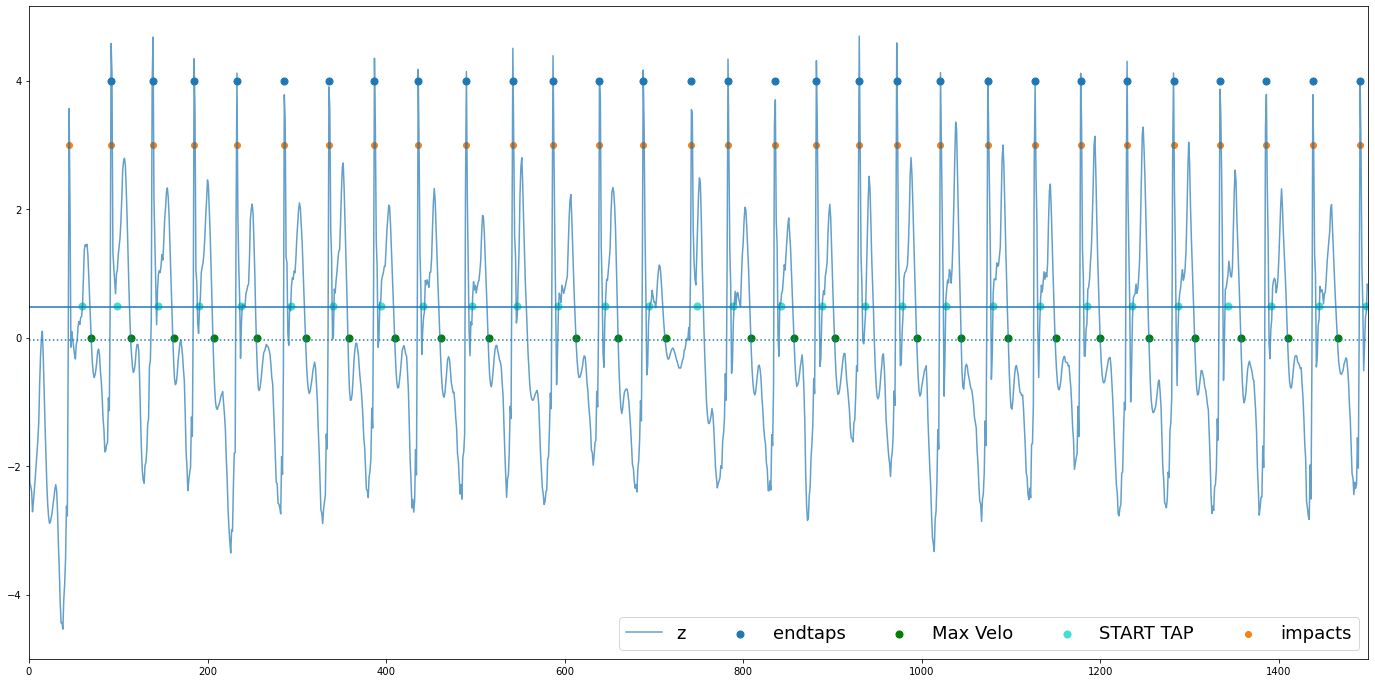

In [624]:
plt.figure(figsize=(24,12))
R=0
T=0
acctemp = accproc545[f'run{R}_t{T}'].T
taptemp = tap545[f'run{R}_t{T}']
imptemp = imp545[f'run{R}_t{T}']
ax=2

rawImp = signal.find_peaks(
    acctemp[:, ax],
    height=np.nanmax(acctemp[:, ax]) * .1,  #np.nanmean(acctemp[:, ax]),
)[0]

negP = signal.find_peaks(
        -1 * acctemp[:, ax],
        height=-.5e-7,
        distance=fs * .1 * .5,
        prominence=abs(np.nanmin(acctemp[:, ax])) * .05,
    )[0]


# plt.plot(acctemp.T[0], alpha=.3, label='x')
# plt.plot(acctemp.T[1], alpha=.3, label='y')
plt.plot(acctemp.T[2], alpha=.7, label='z')
# plt.plot(np.ma.average(acctemp.T[2]), alpha=.7, ls='dotted', label='z-averaged')

# plt.plot(np.diff(acctemp[:, ax]), label='y-diff')

plt.axhline(np.nanmax(acctemp[:, ax]) * .1)
plt.axhline(np.nanmean(acctemp[:, ax]), ls='dotted')

plt.scatter([t[-2] for t in taptemp], [4] * len(taptemp), label='endtaps', s=50)
plt.scatter([t[1] for t in taptemp], [0] * len(taptemp), label='Max Velo', s=50, c='green')
plt.scatter([t[0] for t in taptemp], [.5] * len(taptemp), label='START TAP', s=50, c='turquoise')


plt.scatter(imptemp, [3] * len(imptemp), label='impacts')
# plt.scatter(imptemp + 4, [3] * len(imptemp), label='impact BLANK', s=70, c='gray')
# plt.scatter(rawImp, [2] * len(rawImp), s=80, label='rawImp')

# plt.scatter(negP, [-1] * len(negP), s=80, label='NEG', c='r', alpha=.4)


# plt.scatter(rawImp2, [3.5] * len(rawImp2), label='rawImp2')
# plt.scatter(rawImp3, [3.2] * len(rawImp3), label='rawImp3')

# plt.xlim(0, 500)

plt.xlim(0, 1500)
plt.legend(ncol=8, fontsize=18)
plt.show()

In [537]:
importlib.reload(tap_run)
importlib.reload(tap_times)
importlib.reload(tap_ft_extr)
importlib.reload(tap_fts_set)
importlib.reload(tap_import)
importlib.reload(tap_impact)
importlib.reload(tap_preproc)

<module 'lfpecog_features.tapping_preprocess' from '/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/code/lfpecog_features/tapping_preprocess.py'>

In [649]:
importlib.reload(tap_run)
importlib.reload(tap_times)
importlib.reload(tap_ft_extr)
importlib.reload(tap_fts_set)
importlib.reload(tap_import)
importlib.reload(tap_impact)
importlib.reload(tap_preproc)

jb_dir = '/Users/jeroenhabets/Research/CHARITE/projects/tapping/data/JB_30s'
jb_fig_dir = '/Users/jeroenhabets/Research/CHARITE/projects/tapping/figures/JB_30s'

mat_dat_f = 'tapsMat.mat'
# mat_ax_ids_f = 'channels.mat'
# mat_run_ids_f = 'subSession.mat'

mat = tap_import.matlab_import(os.path.join(
    jb_dir, mat_dat_f))
fname = mat.filename.split(sep='/')[-1]
mat = mat[fname[:-4]]

fs=250

acc545 = mat[:, :, -28:]
fts545 = {}

### check tap detection
tap545 = {}
imp545 = {}
accproc545 = {}

updrs_times = {'t1': (2 * fs, 12 * fs), 't2': (20 * fs, 30 * fs)}

for run_id in np.arange(acc545.shape[2]):
    
    raw_triax = acc545[:, :, run_id].T

    for t_i, t in enumerate(updrs_times.keys()):

        print(f'\nStart run_id {run_id}, timepoint {t_i}')

        sig = raw_triax[
            :, updrs_times[t][0]:updrs_times[t][1]
        ]
        subscore = scores545[run_id, t_i]

        tap_inds, imp_inds, proc_triax = tap_run.run_updrs_tapping(
            acc_arr=sig, fs=fs, already_preprocd=False, #orig_fs=4000,
        )
        ## check tap detect
        tap545[f'run{run_id}_t{t_i}'] = tap_inds
        imp545[f'run{run_id}_t{t_i}'] = imp_inds
        accproc545[f'run{run_id}_t{t_i}'] = proc_triax


        ### ADD CLINICAL UPDRS SCORE TO 10-SEC FEAT-CLASSES
        fts545[f'run{run_id}_t{t_i}'] = tap_ft_extr.tapFeatures(
            triax_arr=proc_triax,
            fs=fs,
            impacts=imp_inds,
            tapDict=tap_inds,  # result of continTap
            updrsSubScore=subscore,
        )




Start run_id 0, timepoint 0

Start run_id 0, timepoint 1

Start run_id 1, timepoint 0

Start run_id 1, timepoint 1

Start run_id 2, timepoint 0

Start run_id 2, timepoint 1

Start run_id 3, timepoint 0

Start run_id 3, timepoint 1

Start run_id 4, timepoint 0

Start run_id 4, timepoint 1

Start run_id 5, timepoint 0

Start run_id 5, timepoint 1

Start run_id 6, timepoint 0

Start run_id 6, timepoint 1

Start run_id 7, timepoint 0

Start run_id 7, timepoint 1

Start run_id 8, timepoint 0

Start run_id 8, timepoint 1

Start run_id 9, timepoint 0

Start run_id 9, timepoint 1

Start run_id 10, timepoint 0

Start run_id 10, timepoint 1

Start run_id 11, timepoint 0

Start run_id 11, timepoint 1

Start run_id 12, timepoint 0

Start run_id 12, timepoint 1

Start run_id 13, timepoint 0

Start run_id 13, timepoint 1

Start run_id 14, timepoint 0

Start run_id 14, timepoint 1

Start run_id 15, timepoint 0

Start run_id 15, timepoint 1
Pos/Neg switched

Start run_id 16, timepoint 0

Start run_id

In [565]:
print(vars(fts545['run0_t0']).keys(), '\n')


dict_keys(['triax_arr', 'fs', 'impacts', 'tapDict', 'updrsSubScore', 'nTaps', 'freq', 'tap_durations', 'freq2', 'runRMS_ax', 'runRMS_svm', 'tapRMS_ax', 'tapRMS_svm', 'upVelo_ax', 'upVelo_svm', 'impactRMS_ax', 'impactRMS_svm']) 



In [322]:
import matplotlib.gridspec as gridspec


freq
runRMS_svm
tapRMS_svm
impactRMS_svm
upVelo_svm


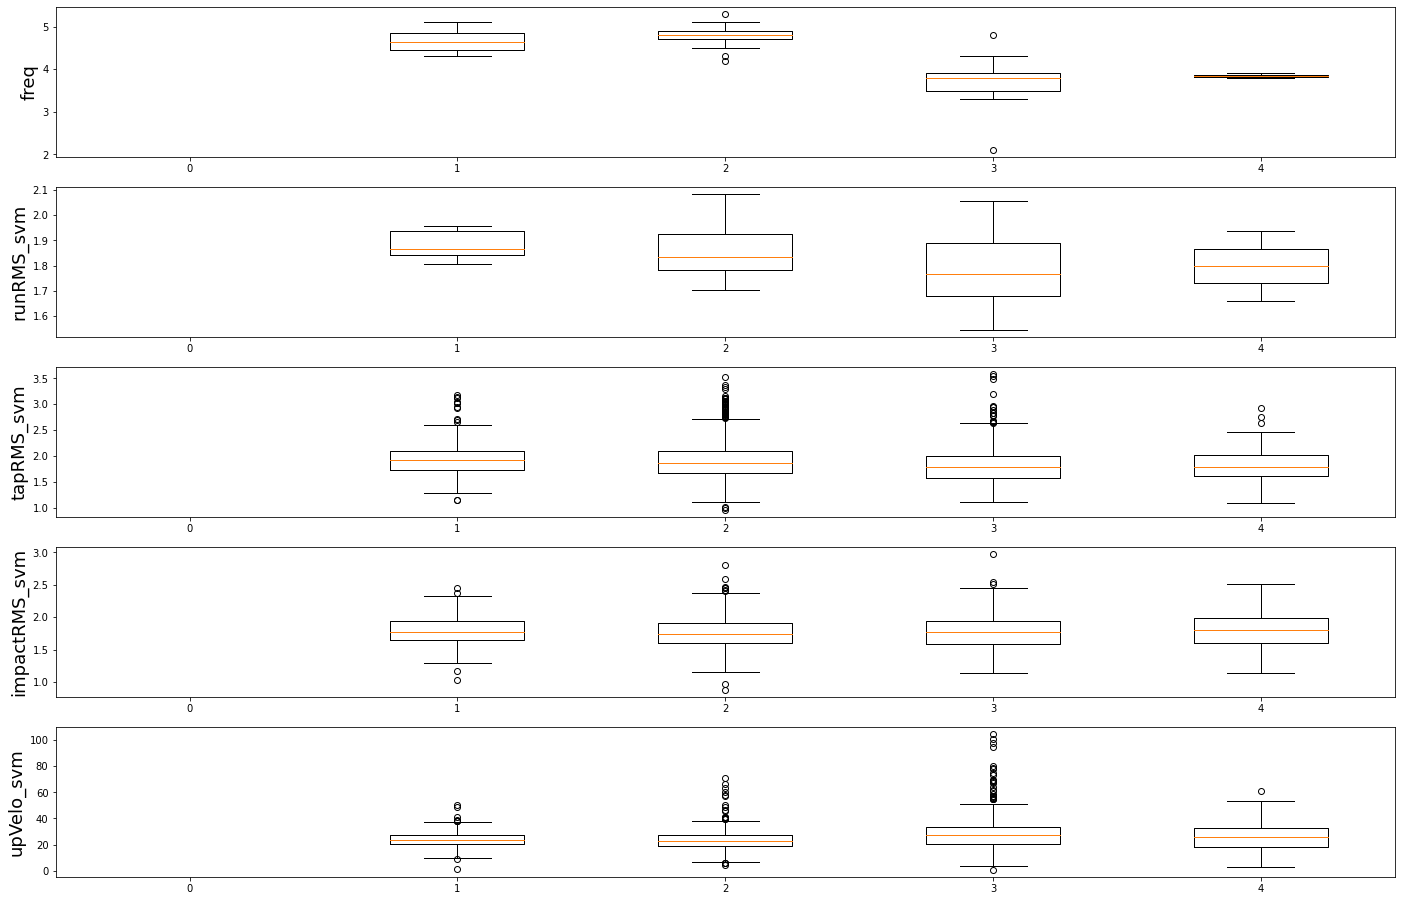

In [653]:
subscores = np.array([fts545[i].updrsSubScore for i in fts545.keys()])
# uniq_scores = np.unique(subscores)
fts_include = [
    'freq',
    'runRMS_svm',
    'tapRMS_svm',
    'impactRMS_svm',
    'upVelo_svm',
]

fig, axes = plt.subplots(len(fts_include), 1, figsize=(24, 16))

for row, ft_sel in enumerate(fts_include):

    print(ft_sel)

    ft_per_score = {}
    for s in np.arange(5): ft_per_score[s] = []
    # for s in uniq_scores: ft_per_score[s] = []

    for i in fts545.keys():
        s = fts545[i].updrsSubScore
        if type(getattr(fts545[i], ft_sel)) == np.ndarray:
            ft_per_score[s].extend(getattr(fts545[i], ft_sel))

        elif type(getattr(fts545[i], ft_sel)) == float or np.float_:
            ft_per_score[s].append(getattr(fts545[i], ft_sel))

    boxscores = [ft_per_score[s] for s in ft_per_score.keys()]

    for i in np.arange(len(boxscores)):

        if np.isnan(np.array(boxscores[i])).any():
            boxscores[i] = np.array(
                boxscores[i]
            )[~np.isnan(np.array(boxscores[i]))]
        else:
            boxscores[i] = np.array(boxscores[i])


    axes[row].boxplot(boxscores)
    # ft_per_score
    # axes[0].set_xticks(np.arange(1, 5))
    axes[row].set_xticklabels(np.arange(0, 5))

    axes[row].set_ylabel(ft_sel, fontsize=18)
# axes[0].set_xlim(-.25, 6.25)
# plt.close()
plt.show()

To do next for acc-feature descriptives:
- include run totals (sum, mean, std)
- include trend or variation over run of specific features
    ESPECIALLY DECLINE OVER RUN (mean first 1/3 vs mean last 1/3??)

- apply on Varvara's data

- apply clustering and classification!

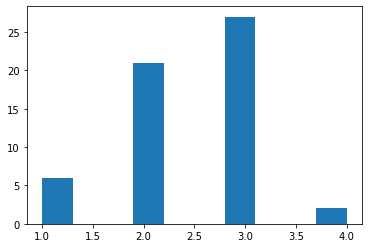

In [333]:
plt.hist(
    x=subscores, #bins=7,
    # align='mid',
)
plt.show()

In [ ]:
# nTaps: int
# freq1: int
# RMS_svm: array
# upVelo_ax: array

In [128]:
vars(fts545[5]).keys()

dict_keys(['triax_arr', 'fs', 'impacts', 'tapDict', 'nTaps', 'freq1', 'tap_durations', 'freq2', 'RMS_ax', 'RMS_svm', 'upVelo_ax', 'upVelo_svm'])

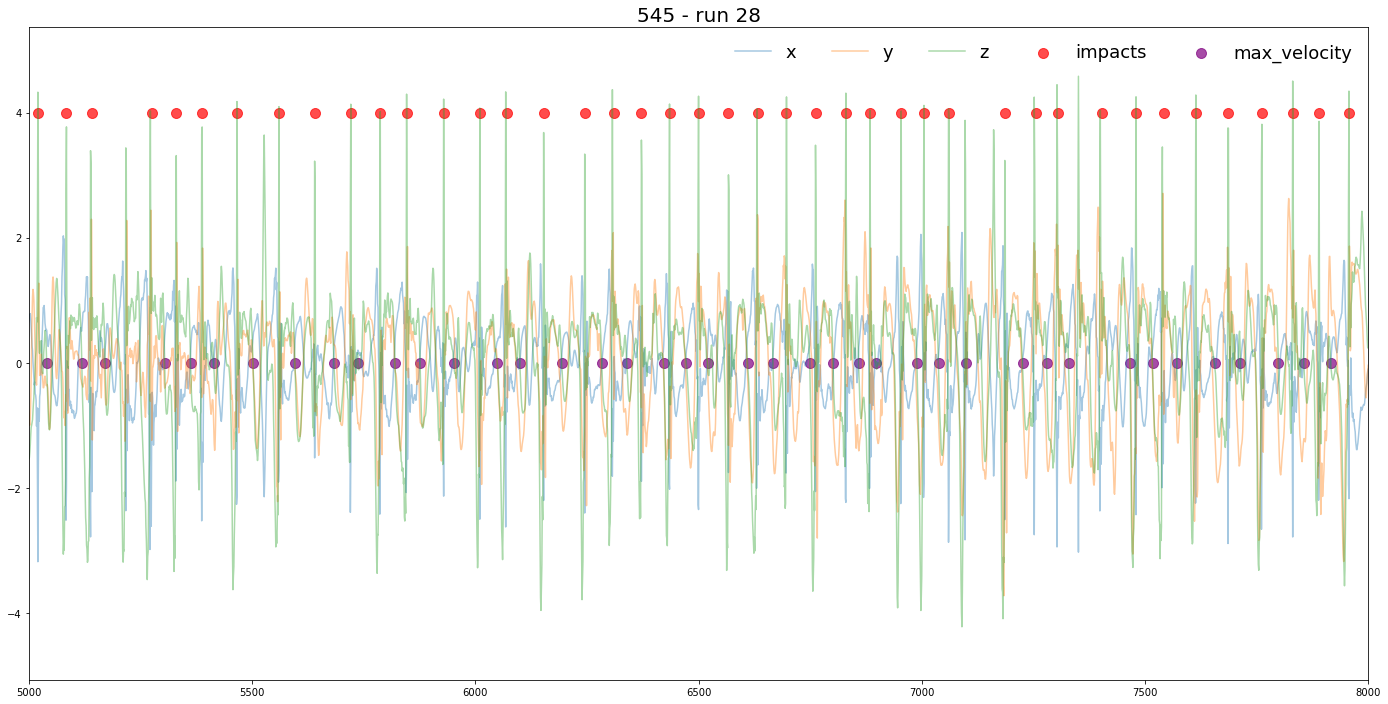

In [140]:
plt.figure(figsize=(24, 12))
velo_max = [t[1] for t in tap_inds]
plt.plot(triax.T, alpha=.4, label=['x', 'y', 'z'])

plt.scatter(imp_inds, [4] * len(imp_inds), c='r',
    label='impacts', s=100, alpha=.7)
plt.scatter(velo_max, [0] * len(velo_max), c='purple',
    label='max_velocity', s=100, alpha=.7)
plt.xlim(5000, 8000)
plt.legend(fontsize=18, ncol=5, frameon=False)
plt.title('545 - run 28', size=20)
plt.savefig(
    os.path.join(jb_fig_dir, 'testshow_impacts_speed_545_good'),
    dpi=150, facecolor='w',)
plt.show()


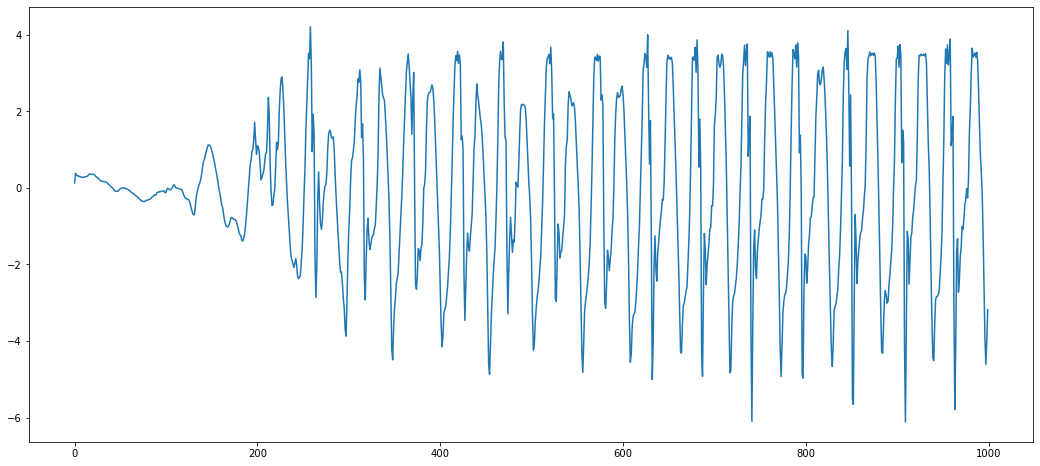

In [17]:
plt.figure(figsize=(18,8))
plt.plot(proc_arr0.T[:1000])

#### Descriptives

In [287]:
names = ['X', 'Y', 'Z', 'SVM']
for i in [0, 1, 2, 3]:
    print(f'AXIS: {names[i]}')
    print(f'Coef of Variation axis {i}: {stats.variation(acc[i, :])}')
    print(f'Median axis {i}: {np.median(acc[i, :])}')
    print(f'Mean axis {i}: {np.mean(acc[i, :])}')
    print(f'Std dev axis {i}: {np.std(acc[i, :])}\n')

AXIS: X
Coef of Variation axis 0: 321381.59409897134
Median axis 0: 0.00013248369214124978
Mean axis 0: 8.256683701341091e-07
Std dev axis 0: 0.2653546169907995

AXIS: Y
Coef of Variation axis 1: -370494.9105419953
Median axis 1: 7.643438584636897e-05
Mean axis 1: -1.7842968783443504e-06
Std dev axis 1: 0.6610729123225516

AXIS: Z
Coef of Variation axis 2: -1484214.2117369594
Median axis 2: -2.061223085547681e-06
Mean axis 2: -2.2165861141118768e-07
Std dev axis 2: 0.3289888612103649

AXIS: SVM
Coef of Variation axis 3: 2.389134896541549
Median axis 3: 0.010657566797215568
Mean axis 3: 0.3029538785770867
Std dev axis 3: 0.723797683351129



#### Peak Detection Epochs 0 and 1

In [522]:
for i in range(10):
        print(np.diff([epoch1[3956 + i], epoch1[3956 + i + 1]]))

[-3.89066702]
[-2.20191675]
[1.03659394]
[0.55430773]
[0.15000268]
[-0.29024918]
[0.23309027]
[0.21614496]
[0.17710242]
[0.0300526]


In [649]:
fig, ax = plt.subplots(1, 1, figsize=(16,6))
clrs=['green', 'orange', 'cyan']
dirs=[1, -1]
epoch1 = acc[1, fs * 50:fs * 75]
svm1 = acc[3, fs * 50:fs * 75]

states = np.zeros((len(epoch1)))

ax.plot(epoch1)
ax.plot(svm1, color='r', alpha=.2)

# find artefacts
art_i=[]
artf = signal.find_peaks(
    epoch1,
    # height=np.max(epoch1) * .5,
    width=(1, 5),
    rel_height=.3,
    distance=fs * 0.2,  # 10 ms
    prominence=np.max(epoch1) * .5,
    wlen=25,
)
print('artfeacts',len(artf[0]))
# for i in artf[0]:  # incl only sharp artf (slope > .5 max)
#     if  epoch1[i] - epoch1[i + 1] > np.max(epoch1) * .3:
#         art_i.append(i)

highPos = signal.find_peaks(
    epoch1,
    height=np.max(epoch1) * .15,
    # width=5,
    # rel_height=.01,
    # distance=fs * 0.01,  # 10 ms
    prominence=np.max(epoch1) * .15,
    # wlen=25,
)
lowPos = signal.find_peaks(
    epoch1,
    height=(-np.max(epoch1) * .3, np.max(epoch1) * .2),
    # width=5,
    # rel_height=.1,
    # distance=fs * 0.01,  # 10 ms
    prominence=np.max(epoch1) * .05,
    # wlen=40,
)
peaksNeg = signal.find_peaks(
    -1 * epoch1,
    # height=np.max(epoch1) * .10,
    width=5,
    distance=fs * 0.01,  # 10 ms
    prominence=np.max(epoch1) * .1,
    # wlen=40,
)

# set states (artf, peak, trough) in one array
for i in np.arange(len(states)):
    if i in artf[0]: states[i] = 4
    elif i in highPos[0]: states[i] = 2
    elif i in lowPos[0]: states[i] = 1
    elif i in peaksNeg[0]: states[i] = -1

for p, peaks in enumerate([highPos, peaksNeg, lowPos]):
    ax.scatter(
        peaks[0],
        # peaks[1]['peak_heights'] * dirs[p],
        epoch1[peaks[0]],
        color=clrs[p],
    )
    print(len(peaks[0]))
ax.scatter(artf[0], epoch1[artf[0]], edgecolor='red', )

# ax[0].plot(states, c='k')

# smth = pd.Series(epoch1).rolling(
#     window=3).median()
# ax[1].plot(smth)

# peaksPos = signal.find_peaks(
#     smth,
#     # height=np.max(smth) * .3,
#     width=5,
#     distance=fs * 0.01,  # 10 ms
#     prominence=np.max(epoch1) * .1,
#     # wlen=40,
# )
# peaksNeg = signal.find_peaks(
#     -1 * smth,
#     # height=np.max(smth) * .3,
#     width=5,
#     distance=fs * 0.005,  # 10 ms
#     prominence=np.max(epoch1) * .1,
#     height=0,
#     # wlen=40,
# )
# for p, peaks in enumerate([peaksPos, peaksNeg]):
#     ax[1].scatter(
#         peaks[0],
#         # peaks[1]['peak_heights'] * dirs[p],  # prominences
#         smth[peaks[0]],  # 
#         color=clrs[p],
#     )

upThr = np.max(epoch1) * .1
phase='pause1'
taps_i = []
tap_ind = [np.nan] * 6
legendDown=False
legendUp=False
# [startUp, fastestUp, highestUp, startDown, fastestDown, closeDown]
for i in np.arange(2770, len(states) - 1):

    if phase == 'decDown1':
        if np.logical_or(
            states[i] == 4,
            np.logical_and(
                states[i] == 2,
                epoch1[i] > np.max(epoch1) * .3
            )
        ):
            phase='closingTap'
    
    elif phase == 'closingTap':
        if np.diff([epoch1[i], epoch1[i + 1]]) > 0:
            # if slope goes up again after big impact peak
            tap_ind[5] = i
            try:
                if not legendDown:
                    ax.fill_betweenx(
                        y=np.arange(-2, 4),
                        x1=tap_ind[3], x2=tap_ind[5],
                        alpha=.3, facecolor='w', hatch='//',
                        edgecolor='gray',
                        label='Down movement',
                    )
                    legendDown=True
                else:
                    ax.fill_betweenx(
                        y=np.arange(-2, 4),
                        x1=tap_ind[3], x2=tap_ind[5],
                        alpha=.3, facecolor='w', hatch='//',
                        edgecolor='gray',
                    )
                
            except:
                print(f'No full tap registered yet: {tap_ind}')
            taps_i.append(tap_ind)  # stire finished tap
            tap_ind = [np.nan] * 6  # set next tap_ind to nan
            phase = 'pause1'

    elif phase == 'pause1':
        if np.logical_and(
            epoch1[i] > upThr,
            np.diff([epoch1[i], epoch1[i + 1]]) > np.max(epoch1) * .03  # was 0.05 adjusted it as tryout for smaller peaks
        ):  # if not > upThr -> stays pause
            phase = 'upAcc1'  # up1 is before up-acc-peak
            tap_ind[0] = i  # START MOVE UP
            # print('start UP', i, phase)

    elif phase == 'upAcc1':  # acc-up before acc-peak
        if np.logical_or(states[i] == 2, states[i] == 4):
            # print('acc up peak found', i)
            phase = 'upAcc2'  # after peak
        # elif epoch1[i] > 0:  # obsolete?
        #     continue
            
    elif phase == 'upAcc2':  # acc-up after acc-peak

        if np.logical_or(states[i] == 2, states[i] == 4):  # new 'start' of move up
            # current one may be false, replace
            phase = 'upAcc1'  # up1 is before up-acc-peak
            tap_ind[0] = i  # START MOVE UP
            # print('start UP correct', i)
        elif epoch1[i] < np.min(epoch1) * .1:  # end upAcc if negative and dropping down
            tap_ind[1] = i  # fastest Up
            phase = 'upDec1'  # deceller UpMove, before neg-peak
            # print('end up, fastest point, new phase:', phase, i)
            continue
        
    elif phase == 'upDec1':  # add if value is neg?
        # print('dec Up active', i)
        if np.diff([epoch1[i], epoch1[i + 1]]) > 0:
            phase = 'upDec2'  # after neg peak
            continue

    elif phase == 'upDec2':  # after (low) pos peak
        if np.logical_or(
            np.logical_or(states[i] == 1, states[i] == 2),
            epoch1[i - 1] > 0
        ):  # small peak or across zero-line
            tap_ind[2] = i  # END of Up movement (highest point)
            phase='pause2'
            if not legendUp:
                ax.fill_betweenx(
                    y=np.arange(-2, 4),
                    x1=tap_ind[0], x2=tap_ind[2],
                    alpha=.2,
                )
                legendUp= True
            else:
                ax.fill_betweenx(
                    y=np.arange(-2, 4),
                    x1=tap_ind[0], x2=tap_ind[2],
                    alpha=.2,
                )
        
    elif phase == 'pause2':
        if np.diff([epoch1[i], epoch1[i + 1]]) < np.min(epoch1) * .05:
            phase='accDown1'  # start of down
            tap_ind[3] = i
            # print('down started', i)
        
    elif phase == 'accDown1':
        if states[i] == -1:  # neg peak
            phase = 'accDown2'
            # print('neg down acc peak', i)
    
    elif phase == 'accDown2':
        if epoch1[i] > 0:  # end of acc down
            tap_ind[4] = i  # fastest point Down
            phase = 'decDown1'
            # if zero-crossing is some point as impact peak
            if np.logical_or(states[i] == 4, states[i] == 2):
                phase = 'closingTap'



     
ax.axhline(0, color='gray', alpha=.5)       
x1=2700
x2=3500
ax.legend(frameon=False)
ax.set_xlim(x1, x2)
ax.set_ylabel('Acc (m/s/s)')
ax.set_xlabel('Time (samples, 250 Hz)')
for s in ['right', 'top']:
    ax.spines[s].set_visible(False)

fname = f'Perc_fingerTap_Test_i{x1}_{x2}'
# plt.savefig(
#     os.path.join(temp_save, 'ACC', 'fingertapping', fname),
#     dpi=150, facecolor='w',
#     )
plt.close()
# plt.show()

'''
POTENTIAL PARAMETERS:
Impact moment: artefact
Fastest moment UP: crossing zero-line between first green peak after artefact and yellow through 
Fastest moment DOWN: crossing zero-line between last yellow trough and artefact

Full tap: start after artefact: green peak -> two good yellow troughs -> green peak or artefact

'''


artfeacts 27
75
90
70


'\nPOTENTIAL PARAMETERS:\nImpact moment: artefact\nFastest moment UP: crossing zero-line between first green peak after artefact and yellow through \nFastest moment DOWN: crossing zero-line between last yellow trough and artefact\n\nFull tap: start after artefact: green peak -> two good yellow troughs -> green peak or artefact\n\n'

False

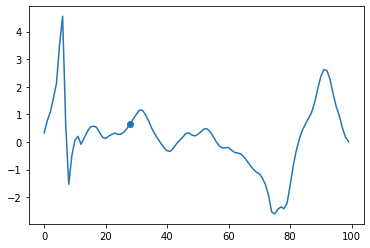

In [628]:
plt.plot(epoch1[3950:4050])
plt.scatter(28, epoch1[3978])
np.diff(epoch1[3956:3958])[0] > np.max(epoch1) * .05

### CLUSTERING ON UPDRS SUB SCORE 4?

In [ ]:
from sklearn.cluster import KMeans

### !! first create 10-sec blocks and use them for clustering/classifying

sides = ['L', 'R']
states = ['On', 'Off']
ids = ['007', '013', '014', '015']
sample_list = []

for id in ids:
    for side in sides:
        for stat in states:
            sample_list.append(f'{id}_{side}_{stat}')
            x_new = np.zeros((1, 4, 300000))  # create too large for all
            axes = getattr(sub_acc[f'{id}_{side}'], stat)
            x_new[0, :axes.shape[0], :axes.shape[1]] = axes
            _, taps = tap_impact.find_impacts(axes[1], fs=250)
            for i in taps: x_new[0, 3, i] = 1

            if len(sample_list) == 1:
                X = x_new
            else:
                X = np.vstack([X, x_new])
            
            

            
# K-means
# DBSCAN
# Laio

X = 


### 1. Patient-Run Definition and Data Loading

#### Print available runs for subject and settings-version

In [5]:
# Explore available preprocessed runs
sub='008'
version='v2.0_Mar22'

importlib.reload(read_data)
read_data.show_runs(
    sub=sub,
    version=version,
    project_path=projectpath,
)


### SHOW RUNS ###
For subject 008, in preproc-version v2.0_Mar22 are available:

LFP_LEFT:
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa00']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa60']
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa10']
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa30']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa35']
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa50']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa15']
['008', 'EcogLfpMedOn02', 'Free', 'StimOffDopa55']
['008', 'EcogLfpMedOn02', 'Free', 'StimOffDopa20']

LFP_RIGHT:
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa30']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa35']
['008', 'EcogLfpMedOn02', 'Rest', 'StimOffDopa00']
['008', 'EcogLfpMedOn02', 'Free', 'StimOffDopa55']
['008', 'EcogLfpMedOn02', 'Free', 'StimOffDopa20']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa60']
['008', 'EcogLfpMedOn02', 'SelfpacedHandTapL', 'StimOffDopa15']
['

#### Select and Load in runs to explore


Not defining task, acquisition or group results in selecting all available options

In [6]:
# Select runs to explore/ ft-extract
importlib.reload(read_data)
fsel, groups, fdir = read_data.select_runs(
    sub=sub,
    version=version,
    project_path=projectpath,
    sess_incl=['EcogLfpMedOn02'],
    tasks_incl=['SelfpacedHandTapL', 'Rest'],
    # acqs_incl=[
    # #     'StimOffDopa00',
    #     'StimOffDopa15',
    #     # 'StimOffDopa35',
    # #     'StimOffDopa50',
    # ],
    # groups_incl=['LFP_RIGHT', 'LFP_LEFT', 'ECOG'],  # if not given, all groups are included
)
# print and check selected runs
# print(fsel)

In [7]:
# Create dataclass per session
# session-dataclass wil contain dict with dataclasses containing
# data per run
importlib.reload(read_data)
SUB08 = read_data.SessionData(fsel, fdir)


In [ ]:
'''
PM: CREATE CLASS WITH WINDOWED FEATURES (EVERY 0.5 / 1 SEC, WITH 50% OVERLAP)

- WINDOWING BASED ON CURRENT SAMPLE-FREQ OF DATATYPE
- IN FT EXTRACTION PROCESS: ADDITIONAL FILTERING BEFORE WINDOWING!
- ADD CLASS WITH VIDEO-BASED EVENT RECOGNITION
    - dysk occurence:
        - coded for bodypart
        - coded for severity?
    - normal movement?
'''

#### Manual Video-Movement Annotation

In [37]:
# annotate observed taps in video, integers are seconds
# from video start
# CAVE: orignal Video-starttime is hour in front
# values here are corrected one hour backwards (12->11)
# Still the video-time seems to be +/- 3 minutes behind
# the acc-neurophys-time
taptimes_video = {
    'SelfpacedHandTapL_StimOffDopa15': {
        'left': [
            1154, 1160, 1164, 1169, 1174, 1180, 1185,
            1191, 1195, 1201, 1207, 1226, 1238, 1243,
            1248, 1253
        ],
        'right':[
            1260, 1264, 1270, 1275, 1281, 1290, 1298,
            1303, 1308, 1313, 1320, 1324, 1332, 1339,
            1345
        ],
        'starttime': '2021-11-15 11:29' 
        # original 11:26 but corrected for mismatching times
    },
    'SelfpacedHandTapL_StimOffDopa35': {
        'left': [
            878, 883, 888, 893, 898, 903, 908, 915,
            919, 926, 933, 946, 951, 957, 963, 970,
            976, 984
        ],
        'right':[
            1000, 1006, 1011, 1017, 1024, 1028, 1035,
            1041, 1054, 1060, 1081, 1089, 1097, 1103,
            1108
        ],
        'starttime': '2021-11-15 11:51:01'
        # original 11:48 but corrected for mismatching times
    },
    'SelfpacedHandTapL_StimOffDopa60': {
        'left': [
            641, 647, 652, 657, 662, 666, 671, 676,
            682, 686, 692, 697, 703, 708, 713, 719,
        ],
        'right':[
            726, 730, 734, 740, 746, 751, 756, 761,
            768, 773, 779, 784, 792, 797, 801
        ],
        'starttime': '2021-11-15 12:22:59'  # video S1290007
        # original 12:20 but corrected for mismatching times
    }
}
# add timedelta in seconds to start-time of video
# CAVE videostarttime is on MINUTE-RESOLUTION
# thus will be SECONDS OF FROM ACC-TIMESTAMP
for run in taptimes_video:
    starttime = pd.Timestamp(taptimes_video[run]['starttime'])
    for side in ['left', 'right']:
        taptimes_video[run][f'{side}_stamps'] = []
        for sec in taptimes_video[run][side]:
            delta = pd.Timedelta(sec, 'sec')
            taptimes_video[run][f'{side}_stamps'].append(
                starttime + delta)

# Save annotation dict
# deriv_dir = os.path.join(
#     projectpath, 'data', 'analysis_derivatives', 'sub-008', 'taps'
# )
# dict_name = f'008_video_ann_tapruns'
# np.save(os.path.join(deriv_dir, dict_name),
#         taptimes_video)

# # Load annotation dict
# video_taps = np.load(os.path.join(deriv_dir, f'{dict_name}.npy'),
#                      allow_pickle=True).item()


In [195]:
sub = '008'
annot_dir = os.path.join(projectpath, f'data/analysis_derivatives/sub-{sub}/taps')
testannot = np.load(os.path.join(annot_dir, f'{sub}_video_ann_tapruns.npy'),
    allow_pickle=True).item()
# testannot


#### Automated Acc-based Tap detection incl. plotting

In [256]:
run = 'SelfpacedHandTapL_StimOffDopa35'
sides = ['left', 'right']
tap_fig_dir = os.path.join(projectpath, 'figures/tapping_detection')

In [390]:
importlib.reload(tap_run)

restTest, tapTest, _ = tap_run.runTapDetection(
    task='paused', fs=SUB08.runs[run].acc_right_Fs,
    leftxyz=[accleft[run][0, :], accleft[run][1, :],
    accleft[run][2, :]], rightxyz=[accright[run][0, :],
    accright[run][1, :], accright[run][2, :]],
)



START left side
1.121970047728486e-07 17 17
logAND is TRUE from rest 366
start of TAP/MOV 1.3276377210030713e-07 366
after lowpeak(UP) coming back up 384
endUP 388
START DOWN MOVEMENT 464
Fastest DOWN MOVEMENT 475
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 1511
start of TAP/MOV 1.1851244079397509e-07 1511
after lowpeak(UP) coming back up 1526
endUP 1539
START DOWN MOVEMENT 1607
Fastest DOWN MOVEMENT 1614
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 2500
start of TAP/MOV 1.303586646046799e-07 2500
after lowpeak(UP) coming back up 2515
endUP 2519
START DOWN MOVEMENT 2594
Fastest DOWN MOVEMENT 2604
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 3499
start of TAP/MOV 1.3153520968013539e-07 3499
after lowpeak(UP) coming back up 3512
endUP 3518
START DOWN MOVEMENT 3601
Fastest DOWN MOVEMENT 3611
ended MOVE bcs next10 inactive
ended MOV

In [356]:
### Main function to perform TapDetection functions
    ## make new main-function

importlib.reload(Tap2)

# accright, accleft = {}, {}
# restDict, tapDict, moveDict = {}, {}, {}

for run in SUB08.runs_incl[1:]:
    print(f'Start RUN: {run}')
    fs=SUB08.runs[run].acc_right_Fs
    accright[run] = SUB08.runs[run].acc_right_arr[1:, :]
    accleft[run] = SUB08.runs[run].acc_left_arr[1:, :]

    restDict[run], tapDict[run], moveDict[run] = runTapDetection(
        task='paused', fs=SUB08.runs[run].acc_right_Fs,
        leftxyz=[accleft[run][0, :], accleft[run][1, :],
        accleft[run][2, :]], rightxyz=[accright[run][0, :],
        accright[run][1, :], accright[run][2, :]],
    )


Start RUN: SelfpacedHandTapL_StimOffDopa60


START left side
1.012731518833157e-07 17 14
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 946
start of TAP/MOV 1.1483229646828269e-07 946
after lowpeak(UP) coming back up 1048
endUP 1055
ended MOVE bcs next10 inactive
logAND is TRUE from rest 2131
start of TAP/MOV 1.2207354651560685e-07 2131
after lowpeak(UP) coming back up 2153
endUP 2157
START DOWN MOVEMENT 2229
Fastest DOWN MOVEMENT 2239
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 3107
start of TAP/MOV 1.2677018217050875e-07 3107
after lowpeak(UP) coming back up 3122
endUP 3126
START DOWN MOVEMENT 3195
Fastest DOWN MOVEMENT 3202
ended MOVE bcs next10 inactive
ended MOVE bcs next10 inactive
logAND is TRUE from rest 4029
start of TAP/MOV 1.2250273844703196e-07 4029
after lowpeak(UP) coming back up 4045
endUP 4050
START DOWN MOVEMENT 4106
Fastest DOWN MOVEMENT 4117
ended MOVE bc

In [ ]:
### (function to be) get runstartTimes (include in RUN CLASS (real and dopa times))
deriv_dir = os.path.join(projectpath, 'data/analysis_derivatives')
runTimes = pd.read_excel(
    os.path.join(deriv_dir, f'sub-{sub}', f'sub{sub}_runsInfo.xlsx'))

runStartTimes = {}
for run in SUB08.runs_incl:
    for row in np.arange(runTimes.shape[0]):
        if run[-6:] in runTimes.iloc[row]['filename']:
            t = runTimes.iloc[row]['acq_time']
            runStartTimes[run] = pd.Timestamp(t)

In [362]:
### Import and process video-annotated tap-times ###

## (function to be) Convert video-annotated tap-stamps
## into seconds after tmsi-recording

# import annotated taptimes (function to be?)
sub = '008'
annot_dir = os.path.join(projectpath, f'data/analysis_derivatives/sub-{sub}/taps')
tapAnnot = np.load(os.path.join(annot_dir, f'{sub}_video_ann_tapruns.npy'),
    allow_pickle=True).item()

ann_times = {}
tapsAnnot_in_runSecs = {}

for run in tapDict.keys():
    if 'Tap' not in run: continue

    # real-time timestamps of video-annotated taps
    dt_string = '%Y-%m-%d %H:%M:%S'
    t0 = tapAnnot[run]['starttime']
    try:
        t0 = dt.datetime.strptime(t0, dt_string)
    except ValueError:
        t0 = dt.datetime.strptime(t0, '%Y-%m-%d %H:%M')

    ann_times[run] = {}
    tapsAnnot_in_runSecs[run] = {}

    for side in sides:
        ann_times[run][side] = [t0 + dt.timedelta(
            seconds=t) for t in tapAnnot[run][side]]
    # minus video start-time -> time after video-start
        tapsAnnot_in_runSecs[run][side] = [
            (t - runStartTimes[run]).total_seconds(
            ) for t in ann_times[run][side]
        ]


In [ ]:
### TO DO:
# - WHY IS check_Polarity turning the signal falsely?
# - Why is tapdetection from TapDopa15 Right empty? 
    # plot incl peaks and thresholds etc

# - include plotting of OTHER MVOEMENTS
# - split py function for tapping in several py docs!!

Plot Figure for run SelfpacedHandTapL_StimOffDopa15


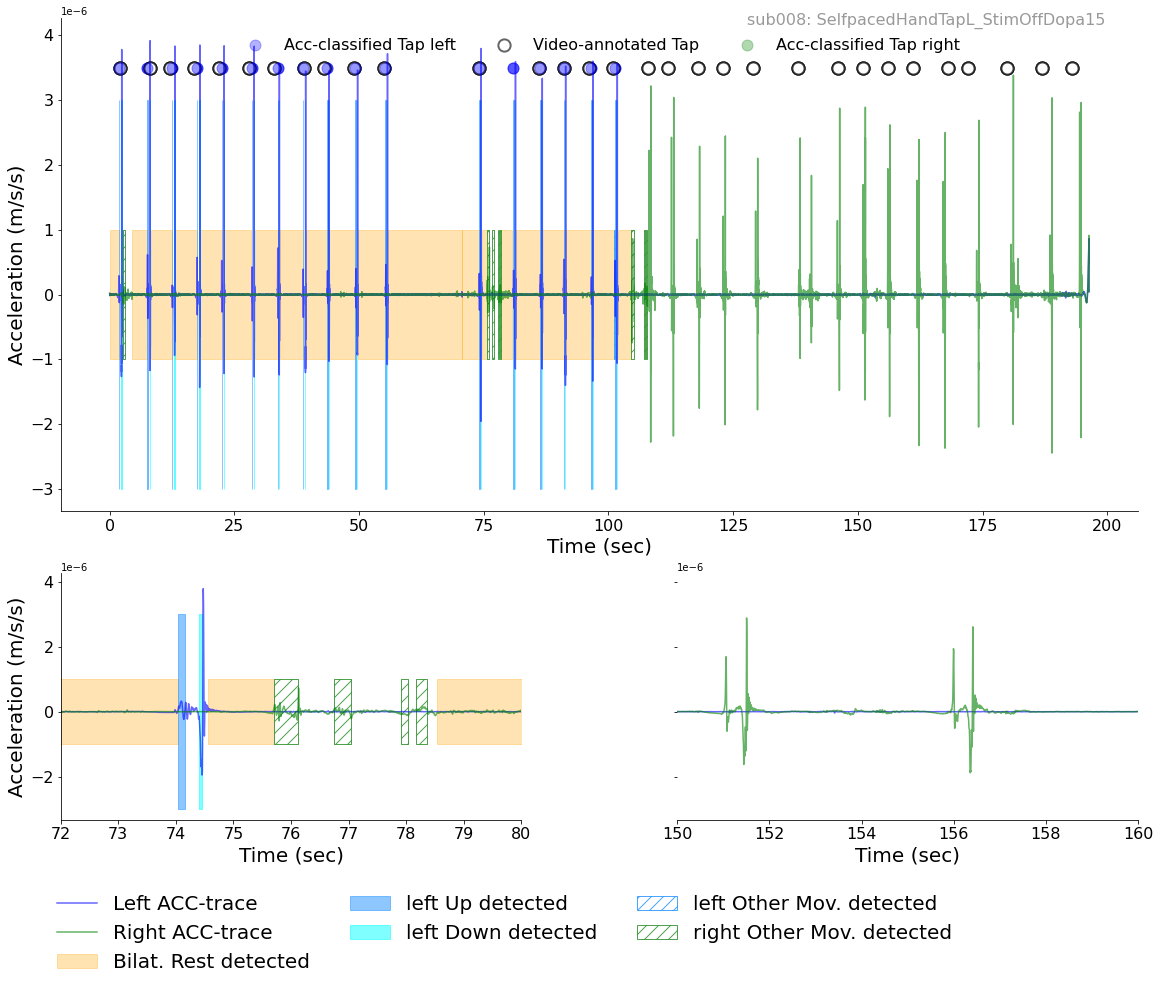

In [379]:
### Create plotting functions for tapping

from matplotlib.gridspec import GridSpec

run = list(tapsAnnot_in_runSecs.keys())[2]

print(f'Plot Figure for run {run}')
# specify x-coordinates of zoomed-in subplots
ax1_x1, ax1_x2 = 72, 80
ax2_x1, ax2_x2 = 150, 160
plot_fname=f'TapDetect_08_{run}'
if ax1_x1: plot_fname += f'_zooms_{ax1_x1}_{ax2_x1}'
plot_fdir=tap_fig_dir

plot_params = {
        'left': {
            'color': 'b',
            'alpha': .6
        },
        'right': {
            'color': 'g',
            'alpha': .6
        },
        'rest': {
            'color': 'orange',
            'alpha': .3
        },
        'left_up': {
            'color': 'dodgerblue',
            'alpha': .5
        },
        'left_down': {
            'color': 'cyan',
            'alpha': .5
        },
        'left_other': {
            'facecolor': 'white',
            'edgecolor': 'dodgerblue',
            'alpha': .8,
            'hatch': '//'
        },
        'right_up': {
            'color': 'forestgreen',
            'alpha': .5
        },
        'right_down': {
            'color': 'lime',
            'alpha': .5
        },
        'right_other': {
            'facecolor': 'white',
            'edgecolor': 'forestgreen',
            'alpha': .8,
            'hatch': '//'
        }
    }

fig = plt.figure(constrained_layout=True, figsize=(16, 12))
gs = GridSpec(3, 9, figure=fig)

ax0 = fig.add_subplot(gs[:2, :])
ax1 = fig.add_subplot(gs[2, :4])
ax2 = fig.add_subplot(gs[2, 5:], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)

for ax in [ax0, ax1, ax2]:
    # Plotting traces
    ax.plot(
        np.arange(0, accleft[run][1, :].shape[0]) / fs,
        accleft[run][1, :], **plot_params['left'],
        label='Left ACC-trace',
    )
    ax.plot(
        np.arange(0, accright[run][1, :].shape[0]) / fs,
        accright[run][1, :], **plot_params['right'],
        label='Right ACC-trace',
    )
    # Plot bilateral Rest-epochs
    for d in restDict[run]:
        ax.fill_betweenx(label='Bilat. Rest detected',
            y=[-1e-6, 1e-6], x1=restDict[run][d][0],
            x2=restDict[run][d][1],
            **plot_params['rest'],)

    # Plot Tap and other-movem. epochs
    for side in ['left', 'right']:
        ## plot Taps
        for t, tList in enumerate(tapDict[run][side]):
            ax.fill_betweenx(
                y=[-3e-6, 3e-6],
                x1=tList[0], x2=tList[2],
                label=f'{side} Up detected',
                **plot_params[f'{side}_up'],
            )
            # ax.scatter(tList[1], )  # plot fastest point
            ax.fill_betweenx(
                y=[-3e-6, 3e-6],
                x1=tList[3], x2=tList[4],
                label=f'{side} Down detected',
                **plot_params[f'{side}_down'],
            )
        
        ## Plot Other Movement's
        for t, tList in enumerate(moveDict[run][side]):
            ax.fill_betweenx(
                y=[-1e-6, 1e-6],
                x1=tList[0], x2=tList[1],
                label=f'{side} Other Mov. detected',
                **plot_params[f'{side}_other'],
            )
        
        ## Plot Accuracy circles based on video-annotations
        vid_circle_pos = tapsAnnot_in_runSecs[run][side]
        acc_circle_pos = [t[0] for t in tapDict[run][side]]
        ax0.scatter(
            vid_circle_pos, [3.5e-6] * len(vid_circle_pos),
            s=150, edgecolor='k', facecolor='w', lw=2,
            label='Video-annotated Tap', **plot_params['left'],
        )
        ax0.scatter(
            acc_circle_pos, [3.5e-6] * len(acc_circle_pos),
            s=120, color=plot_params[side]['color'], alpha=.3,
            label=f'Acc-classified Tap {side}'
        )
        tapAcc_handles, tapAcc_labels = ax0.get_legend_handles_labels()
        tapAcc_handles = tapAcc_handles[-3:]
        tapAcc_labels = tapAcc_labels[-3:]
        ax0.legend(tapAcc_handles, tapAcc_labels,
            fontsize=16, ncol=3, frameon=False,
            loc='upper center', bbox_to_anchor=(.5, .99))

        # plot findpeak dots to optimize algorithm
        # posPeaks = signal.find_peaks(
        #     accleft[run][1, :],
        #     height=np.max(accleft[1, :]) * .5,
        #     distance=fs,  # 1 s
        # )
        # ax.scatter(posPeaks[0] / fs, posPeaks[1]['peak_heights'], c='k')
        # posPeaks = signal.find_peaks(
        #     accright[run][1, :],
        #     height=np.max(accright[1, :]) * .5,
        #     distance=fs,  # 1 s
        # )
        # ax.scatter(posPeaks[0] / fs, posPeaks[1]['peak_heights'], c='gray')
        
        
    # make plots pretty
    ax.set_xlabel('Time (sec)', size=20)
    ax.tick_params(axis='both', which='both', labelsize=16)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # helping lines for alforithm finetuning
    # ax.axhline(np.median(spos), label='median')
    # ax.axhline(np.percentile(spos, 75), label='75-%', ls='dotted')
    # ax.axhline(-np.percentile(spos, 75), label='-75-%', color='red', ls='dotted')

# make plot pretty
for ax in [ax0, ax1]: ax.set_ylabel('Acceleration (m/s/s)', size=20)
ax2.spines['left'].set_visible(False)

# define zoomed subplots
ax1.set_xlim(ax1_x1, ax1_x2)
ax2.set_xlim(ax2_x1, ax2_x2)

# get rid off duplicate legend labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(), by_label.keys(),
    fontsize=20, frameon=False, ncol=3,
    loc='upper left', bbox_to_anchor=(.03, -.01)
)
plt.suptitle(f'sub008: {run}', x=.8, y=.99,
    color='gray', alpha=.8, fontsize=16,)
# plt.tight_layout(pad=.1)

plt.savefig(os.path.join(plot_fdir, plot_fname),
    dpi=150, facecolor='white', bbox_inches='tight')

plt.show()

In [489]:
### PLOTTING ###
## using xyz input and output-indices of pausedTap function
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(xEpoch, label='x', alpha=.5, c='blue')
ax.plot(yEpoch, label='y', alpha=.8, c='green')
ax.plot(zEpoch, label='z', alpha=.5, c='orange')
# plot vertical lines at tap-moments
for t, tap in enumerate(tapi):
    if t == 0:
        ax.axvline(tap[0], c='green', ls='dotted', alpha=.5, label='start UP')
        ax.axvline(tap[1], c='green', ls='solid', alpha=.5, label='end UP')
        ax.axvline(tap[2], c='purple', ls='dotted', alpha=.5, label='start DOWN')
        ax.axvline(tap[3], c='purple', ls='solid', alpha=.5, label='end DOWN')
    else:
        ax.axvline(tap[0], c='green', ls='dotted', alpha=.5,)
        ax.axvline(tap[1], c='green', ls='solid', alpha=.5,)
        ax.axvline(tap[2], c='purple', ls='dotted', alpha=.5,)
        ax.axvline(tap[3], c='purple', ls='solid', alpha=.5,)

peaklabel = ['lowPos', 'highPos', 'lowNeg', 'highNeg']
peakcol = ['lightgreen', 'green', 'orange', 'r']
for p, peaks in enumerate([smallPos, largePos, smallNeg, largeNeg]):
    ax.scatter(
        peaks[0],
        yEpoch[peaks[0]],
        label=peaklabel[p],
        color=peakcol[p],
        s=50,
    )

for mov in movei:  # check saved otherMovements
    ax.axvline(mov[0], color='gray', lw=1, ls='dotted')
    ax.axvline(mov[-1], color='gray', lw=1)

# ax.axhline(-.5e-7)
ax.axhline(posThr)
ax.axhline(0, c='gray', lw=.5,)
# determine what to show
ax.set_ylim(-2.5e-6, 2.5e-6)
# ax.set_xlim(istart, istop)
ax.set_xlim(0, 30000)
# ax.set_xticks(np.arange(18600, 20001, 200))
# ax.set_xticklabels(np.arange(18600, 20001, 200) // 200)
xticks = np.arange(0, len(yEpoch), 6000)
xlabs = np.arange(0, len(yEpoch) / 12000, .5)
ax.set_xticks(xticks)
ax.set_xticklabels(xlabs)

ax.set_ylabel('Raw Acceleration (m/s/s)', size=14)
ax.set_xlabel('Time (minutes)', size=14)

ax.set_title(run)

# ax.legend(frameon=False, fontsize=14, loc='upper right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot Rest-moments
for idx in resti:
    ax.fill_betweenx(
        y=np.linspace(-3e-6, 3e-6, 5), x1=idx[0], x2=idx[1],
        color='blue', alpha=.1,)

if to_save:
    plt.savefig(
        os.path.join(temp_save, 'ACC', f'mountFingerTap_sub08_{run[-6:]}_2'),
        dpi=300, facecolor='w',
    )
plt.show()

print(f'{run} finisihed')

169.42

In [64]:
tempdir = ('/Users/jeroenhabets/Research/CHARITE/projects/'
    'dyskinesia_neurophys/data/analysis_derivatives/sub-008/May03')


In [471]:
def SelAndSave_Restblocks(
    neu_data, fs, neu_names, restTimes, runname, winlen=1024,
    neu_ch_incl=[],
):
    for neu_chi in np.arange(1, neu_data.shape[0]):
        neudat = neu_data[neu_chi, :]
        neuTimes = neu_data[0, :]
        neu_ch = neu_names[neu_chi]  # channel name
        print(neu_ch)
        if neu_ch_incl:
            if neu_ch not in neu_ch_incl: continue

        tempdat = np.zeros((1, winlen))
        rowTimes = []  # list to store times corresponding to data rows

        for n, timeIdx in enumerate(restTimes[1:-1]):  # skip first and last
            neuInd1 = np.where(neuTimes == timeIdx[0])[0][0]
            neuInd2 = np.where(neuTimes == timeIdx[1])[0][0]
            dat_sel = neudat[neuInd1:neuInd2]
            n_wins = len(dat_sel) // winlen
            dat_sel = np.reshape(
                dat_sel[:n_wins * winlen],
                (n_wins, winlen),
                order='C',  # fills row after row
            )
            tempdat = np.vstack([tempdat, dat_sel])
            for i in np.arange(n_wins):
                rowTimes.append(timeIdx[0] + (i * winlen / fs))

        rowTimes = np.round(rowTimes, 3)  # round .019999 values
        tempdat = tempdat[1:, :]  # exclude first row of zeros

        # saving data array
        fname = f'{runname}_{neu_ch}_win{winlen}'
        # np.save(os.path.join(
        #     tempdir, 'restblocks', f'restBlocks_sub08_{fname}'), tempdat)
        # save list of rowtimes
        np.save(os.path.join(
            tempdir, 'restblocks', f'restTimes_sub08_{fname}'), rowTimes)


    # return tempdat, rowTimes

In [165]:
neusource = 'lfp_left'
_, _ = SelAndSave_Restblocks(
    neu_data = getattr(SUB08.runs[run], f'{neusource}_arr'),
    fs = getattr(SUB08.runs[run], f'{neusource}_Fs'),
    neu_names = getattr(SUB08.runs[run], f'{neusource}_names'),
    restTimes=restTimes,
    runname=run[-6:],
)

### OLD HANDTAP DETECT

In [272]:
importlib.reload(handTap_detect)
# define file with manual video-annotations
tap_ann_file = os.path.join(
    projectpath, 'data', 'analysis_derivatives', 'sub-008',
    'taps', '008_video_ann_tapruns.npy')
# run function
blocks = handTap_detect.handTapDetector(
    SubClass=SUB08,
    check_plots=False,
    # check_plots=False,
    runs_excl=[
#         'Rest_StimOffDopa00', 'Rest_StimOffDopa30',
#  'SelfpacedHandTapL_StimOffDopa35',
#  'Rest_StimOffDopa10',
#  'Rest_StimOffDopa50',
#  'SelfpacedHandTapL_StimOffDopa15'
    ],
    plotdir=os.path.join(temp_save, 'ACC'),
    plot_annot=tap_ann_file,
    buffsec=.05,
    TAPthr=2e-7,
    MOVthr=1e-7,
    savedir=os.path.join(
        projectpath, f'data/preprocess/sub-{sub}/'
        f'/acc/acc_taps_sub{sub}'),
)


Start Rest_StimOffDopa00

Start SelfpacedHandTapL_StimOffDopa60

Start Rest_StimOffDopa30

Start SelfpacedHandTapL_StimOffDopa35

Start Rest_StimOffDopa10

Start Rest_StimOffDopa50

Start SelfpacedHandTapL_StimOffDopa15


In [267]:
for run in [
    'SelfpacedHandTapL_StimOffDopa15',
    'SelfpacedHandTapL_StimOffDopa35',
    'SelfpacedHandTapL_StimOffDopa60'
]:
    print(run)
    for side in ['left', 'right']:
        print([len(blocks[run][side]['Taps'][k]) for k in
            blocks[run][side]['Taps']])

SelfpacedHandTapL_StimOffDopa15
[130, 124, 116, 130, 110, 94, 76, 111, 76, 79, 77, 99, 87, 84, 87, 91]
[137, 168, 116, 137, 126, 128, 95, 113, 114, 122, 118, 120, 116, 120, 92]
SelfpacedHandTapL_StimOffDopa35
[107, 111, 102, 82, 84, 88, 78, 99, 103, 166, 119, 60, 99, 113]
[128, 178, 122, 97, 129, 100, 110, 116, 118, 171, 66, 101, 188, 156, 131, 123, 167]
SelfpacedHandTapL_StimOffDopa60
[162, 130, 116, 105, 116, 115, 109, 94, 117, 137, 114, 100, 116, 74, 112]
[165, 165, 138, 149, 118, 139, 132, 132, 127, 123, 116, 175, 121, 146, 142]


In [177]:
a = np.array([5555 , 6600, 7000])
a / 200

array([27.775, 33.   , 35.   ])

In [263]:
# Plot figures to check identified acticity blocks per block

blockdict = blocks
for run in [
    'SelfpacedHandTapL_StimOffDopa15',
    'SelfpacedHandTapL_StimOffDopa35',
    'SelfpacedHandTapL_StimOffDopa60'
]:
    nrows=20
    thr = 5e-7
    fig, axes = plt.subplots(nrows, 2, figsize=(16,12),
        sharey='row',)
    # axes = axes.flatten()
    ls = {'left': 'solid', 'right': 'dotted'}
    state='Taps'
    xdiff = 100

    for s, accside in enumerate(['left', 'right']):
        runclass = SUB08.runs[run]
        acc_svm = np.sqrt(
            getattr(runclass, f'acc_{accside}_arr')[1, :]**2 +
            getattr(runclass, f'acc_{accside}_arr')[2, :]**2 +
            getattr(runclass, f'acc_{accside}_arr')[3, :]**2
        )

        for b in np.arange(nrows):
            try:
                acc0 = int(blockdict[run][accside][state][b][0] * 200)
            except KeyError:
                for sp in ['left', 'right', 'top', 'bottom']:
                    axes[b, s].spines[sp].set_visible(False)
                axes[b, s].set_ylabel(f'{b}', size=14)
                axes[b, s].set_xticks([])
                axes[b, s].set_yticks([])
                continue
            acc1 = int(blockdict[run][accside][state][b][-1] * 200)
            axes[b, s].plot(acc_svm[acc0 - xdiff:acc1 + xdiff],
                alpha=.5, label=accside)
            axes[b, s].axvline(x=xdiff)
            axes[b, s].axvline(x=xdiff + acc1 - acc0)
            axes[b, s].set_yticklabels([])
            if s == 0: axes[b, s].set_ylabel(f'{b}', size=14)
            for a in ['right', 'top']:
                axes[b, s].spines[a].set_visible(False)
        axes[0, s].set_title(f'{accside.upper()}', size=14)

    plt.suptitle(run, color='gray', size=14)
    plt.tight_layout(h_pad=0.0, w_pad=0.0)
    fig.savefig(os.path.join(
        temp_save, 'ACC',
        f'single_{state}_sub08_{run[-6:]}_LR_v4'
    ), dpi=150, facecolor='w',)
    plt.close()

    #### TODO:
    ### New Tap detection:
    ## USE Y-axis
    ## SEARCH for double sinusoid for one tap (+ - - +)
    #   one sinusoid (+ -) is raising hand
    #   one sinusoid (- +) is lowering hand
    # PM: use impact-artifact as backup-tap detection
    # - SPLIT THRESHOLDS FOR TAP DETECT VS DYSK/ELSE DETECT
    # - ANNOTATE VIDEO WITH DYSKINETIC MOVEMENTS TO CHECK NEW ALGORITHM

In [ ]:
'''
IMPORTANT: CHECK VIDEO - TMSi TIME DIFF
# second left-mov (tap) in video at 19:19
# -> video Timestamp('2021-11-15 11:45:20')
# -> acc from 2021-11-15 11:48:19.395000 
#           to 2021-11-15 11:48:20.300000

# first right-mov (dysk) in video at 19:14
#  -> video Timestamp('2021-11-15 11:47:00')
#  -> acc from 2021-11-15 11:48:14.505000
#           to 2021-11-15 11:48:16.040000

# Rest recording starts in video at 12:52
# -> video first movements right between 13:00 +/- 00:02:
#   stamp is 11:26:00 + 00:13:00 -> 11:39:00 +/- 00:02
# IN ACC: 11:42:00 +/- 00:02
# ERGO: For Rest10, Tapping15: ACC-time is 03:00 ahead of Video

## TODO / Finish:
- PREPROC: INCLUDE TIME (t) and TimeSTAMPS (ts) to arrays
- PREPROC: downssample to higher freq for short term analyssi
- differentiation in algorithm between dyskinetic movement and tap
- test algorithm on different Subjects

